<a href="https://colab.research.google.com/github/beepmo/gator/blob/main/data/06-20/litao3_gating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import userdata
import plotly.express as px


# 1. Set up project in runtime
Create colab secrets for the following credentials for the repo to get runtime files and clone repo

In [2]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/beepmo/gator
%pwd

Cloning into 'gator'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 357 (delta 80), reused 21 (delta 10), pack-reused 197
Receiving objects: 100% (357/357), 15.86 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (156/156), done.


'/content'

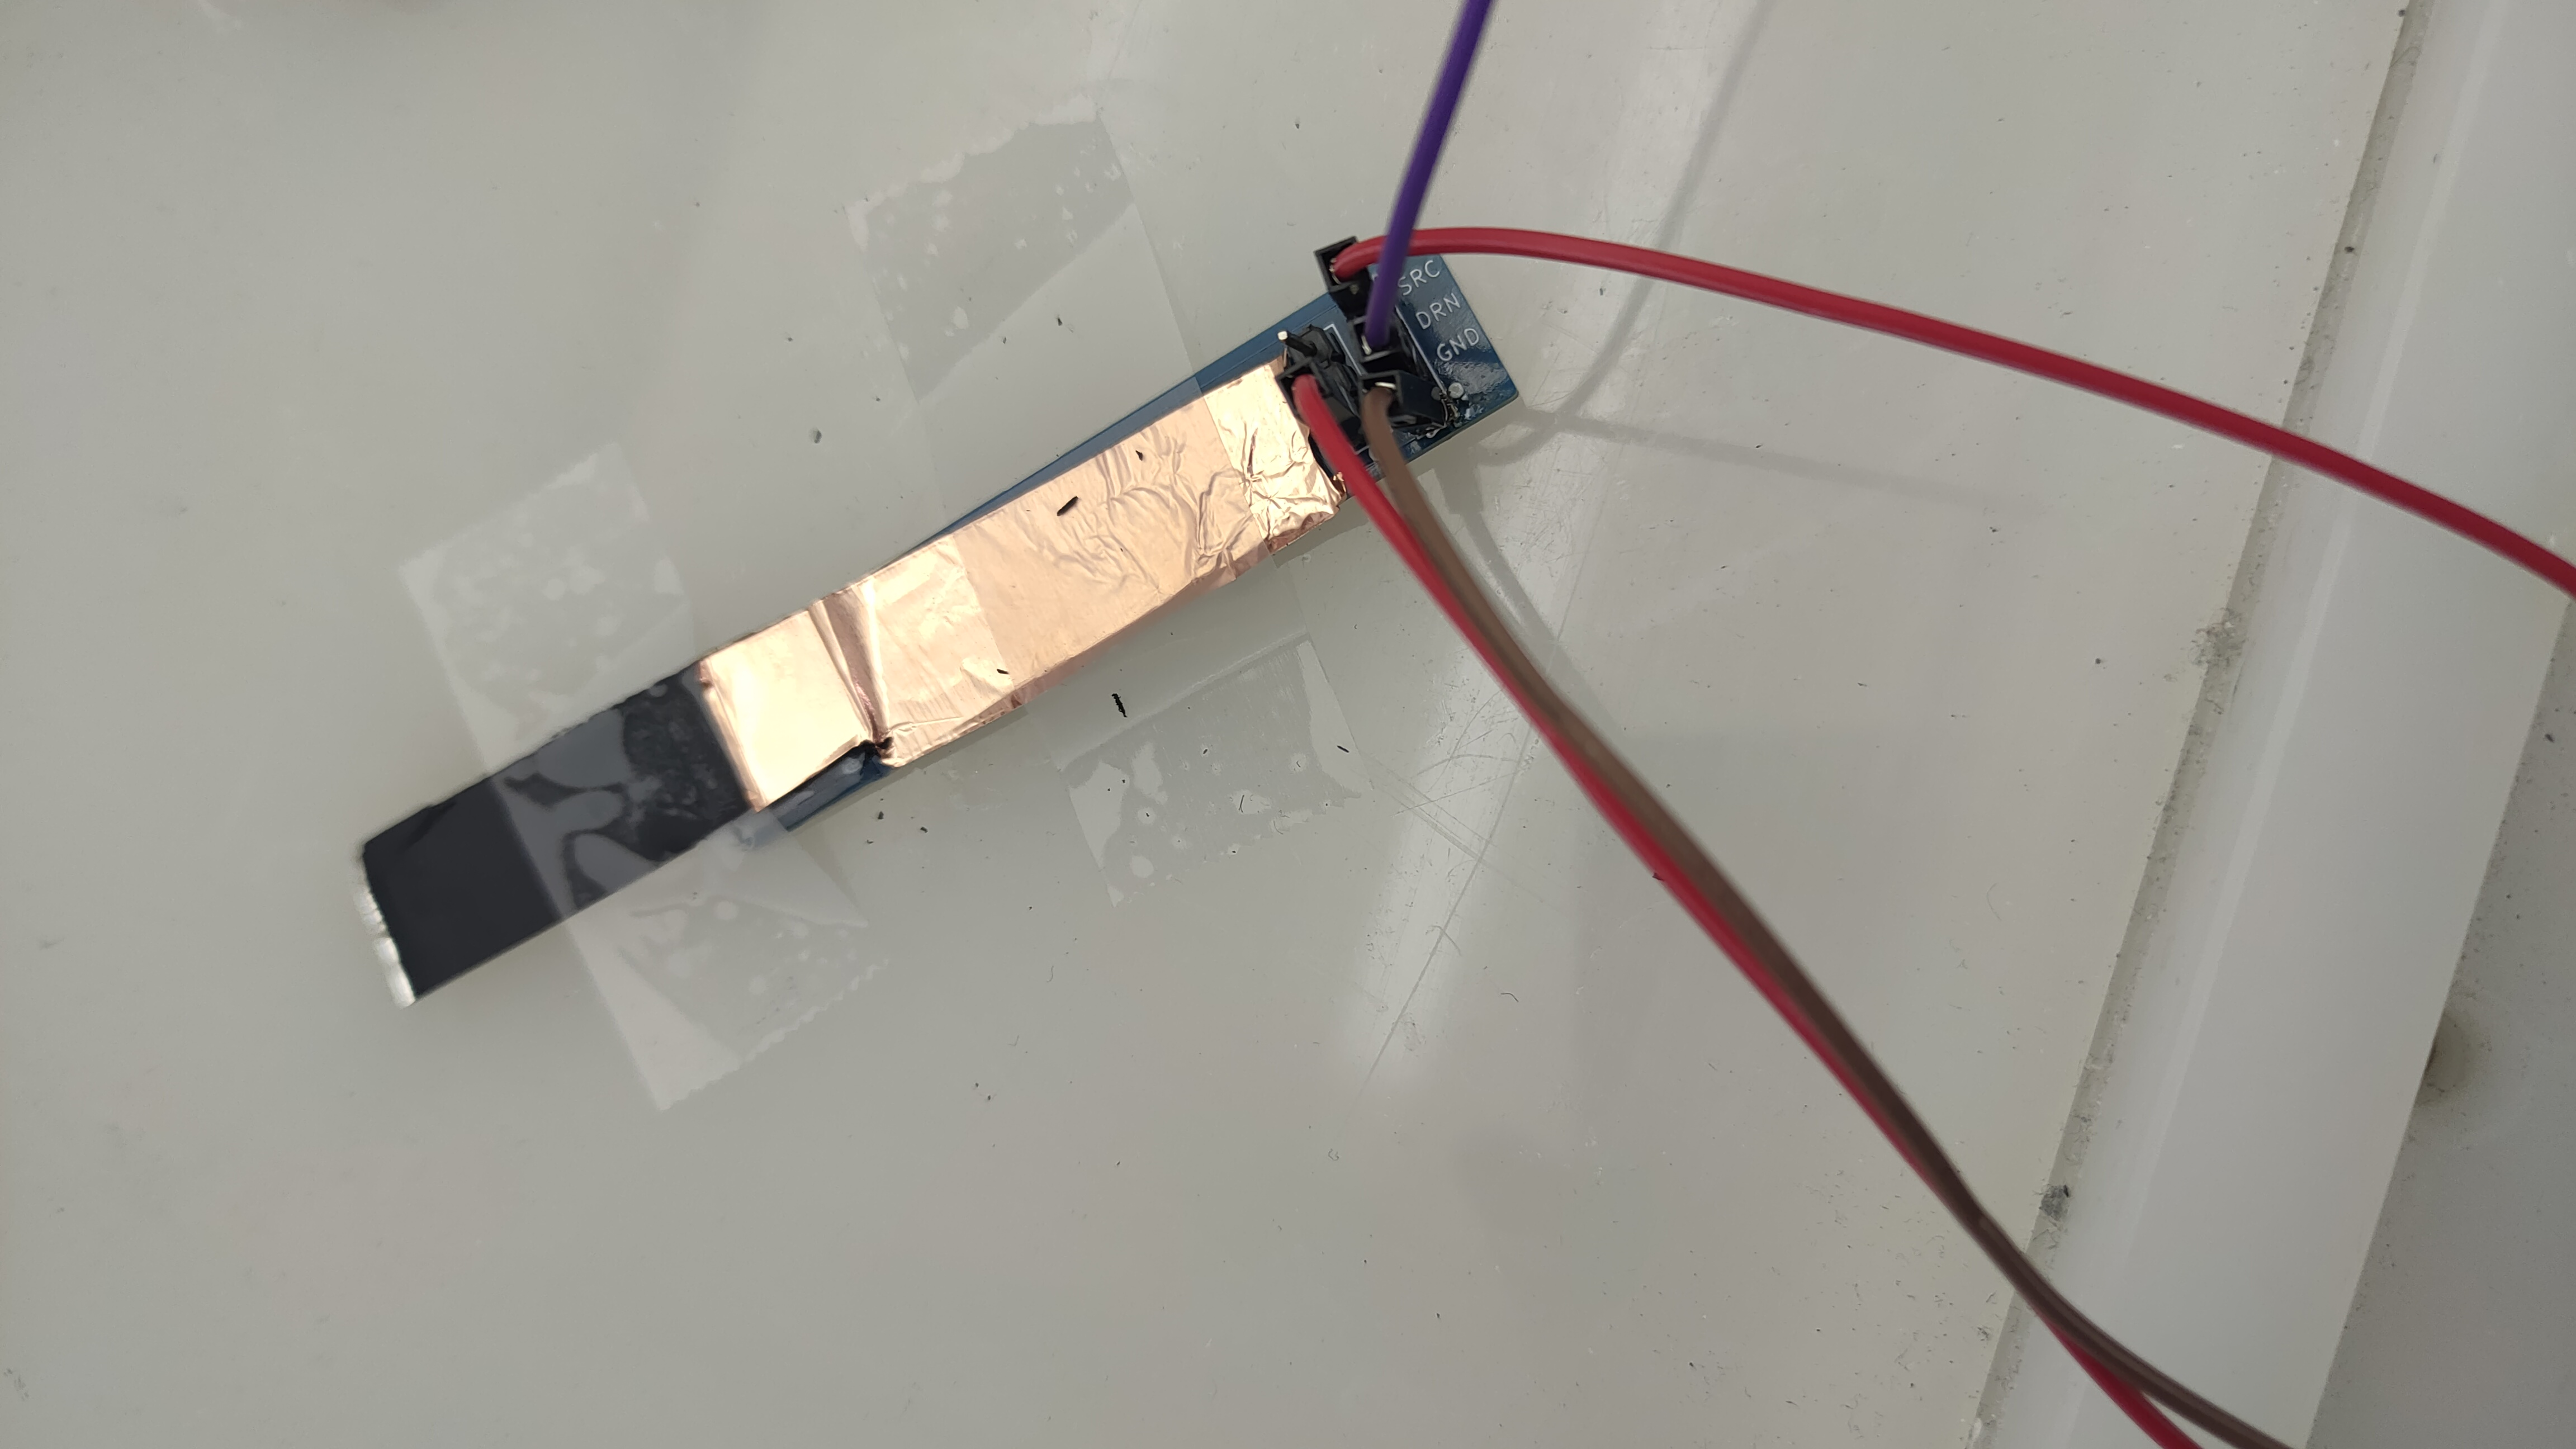

# 14-06-24 LiTaO3 gating

- Frequency : 10 mV
- Amplitude : 1 Vpp
- Offset : 521 mV

- Duty Cycle : 75%



# Base Time
06/13/2024 12:51

In [ ]:
%cd "/content/gator/data/06-14"

/content/gator/data/06-14


In [ ]:
# prompt: delete first 8 lines from full_buffer.csv

def prep_csv(filename):

  # Read the full buffer into a list of lines
  with open(filename, 'r') as f:
    lines = f.readlines()

  # print base time
  print(lines[7])

  # Delete the first 8 lines
  lines = lines[8:]

  # Write the remaining lines back to the file
  with open(filename, 'w') as f:
    f.writelines(lines)

In [ ]:
prep_csv('defbuffer1_0613_125032.csv')
df = pd.read_csv('defbuffer1_0613_125032.csv')


Base Time,06/13/2024 11:18:50.362526920



In [ ]:
df

,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,Limit2 Low,...,Questionable,Origin,Value,Unit.1,Digits,Output,Sense,Source Limit,Overtemp,Relative Time
0,1.810867e-09,Amp DC,1.000000e-07,6.5,F,F,F,F,F,F,...,F,Main,0.971714,Volt DC,1,T,2W,F,F,0.000000
1,1.907257e-09,Amp DC,1.000000e-07,6.5,F,F,F,F,F,F,...,F,Main,0.967776,Volt DC,1,T,2W,F,F,0.721754
2,2.069332e-09,Amp DC,1.000000e-06,6.5,F,F,F,F,F,F,...,F,Main,0.999982,Volt DC,1,T,2W,F,F,1.270608
3,1.863821e-09,Amp DC,1.000000e-07,6.5,F,F,F,F,F,F,...,F,Main,0.969411,Volt DC,1,T,2W,F,F,2.060477
4,2.076380e-09,Amp DC,1.000000e-06,6.5,F,F,F,F,F,F,...,F,Main,0.999985,Volt DC,1,T,2W,F,F,2.609335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,2.228867e-06,Amp DC,1.000000e-05,6.5,F,F,F,F,F,F,...,F,Main,0.999975,Volt DC,1,T,2W,F,F,5501.943287
67926,2.228645e-06,Amp DC,1.000000e-05,6.5,F,F,F,F,F,F,...,F,Main,0.999976,Volt DC,1,T,2W,F,F,5502.012794
67927,2.228651e-06,Amp DC,1.000000e-05,6.5,F,F,F,F,F,F,...,F,Main,0.999976,Volt DC,1,T,2W,F,F,5502.082160
67928,2.228597e-06,Amp DC,1.000000e-05,6.5,F,F,F,F,F,F,...,F,Main,0.999974,Volt DC,1,T,2W,F,F,5502.151474


In [ ]:
# Time (s)
T = df['Relative Time']

# Current (mA)
I = df['Reading'] * 1e9

# Potential (mV)
V = df['Value'] * 1e3

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

<ipython-input-10-e44d9732e7c6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)


In [ ]:
# prompt: generately plotly express scatter plots of current and voltage over time from df_new

# fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)", "Vds (1e-2 V)"])
fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)"])
fig.show()